# Estimate cross pol

Estimate best $\chi_{pol}$

### Mar 9, 2021

## Code

In [44]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [45]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

In [46]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

## Expected polarization 

In [47]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

def estimateRecAngle(depth):
    #Take depth of pulser and calculate the receiving angle at the antenna
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    return 180-np.degrees(np.arccos(path.received_direction[2]))

In [48]:
depthArr = []
pol = []
launchAng = []
for depth in range(600,1200):
    depthArr.append(depth)
    pol.append(abs(estimatePolRayTracer(depth)[0]))
    launchAng.append((estimatePolRayTracer(depth)[1]))

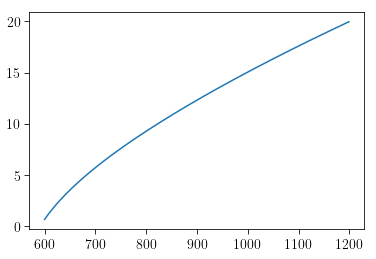

In [49]:
plt.plot(depthArr,(np.array(pol)))
# plt.xlim(600,650)

# Compare to real data

# Dec 24

In [50]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012559.pkl")
SpiceCore0 = SpiceCore0.loc[(SpiceCore0.theta_reco>=90) & (SpiceCore0.power_H>0) & (SpiceCore0.power_V>0)]
SpiceCore0 = SpiceCore0.drop(columns=['Omega_reco'])

SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012559.pkl")
SpiceCore1 = SpiceCore1.loc[(SpiceCore1.theta_reco>=90) & (SpiceCore1.power_H>0) & (SpiceCore1.power_V>0)]
SpiceCore1 = SpiceCore1.drop(columns=['Omega_reco'])

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012559.pkl")
SpiceCore2 = SpiceCore2.loc[(SpiceCore2.theta_reco>=90) & (SpiceCore2.power_H>0) & (SpiceCore2.power_V>0)]
SpiceCore2 = SpiceCore2.drop(columns=['Omega_reco'])

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012559.pkl")
SpiceCore3 = SpiceCore3.loc[(SpiceCore3.theta_reco>=90) & (SpiceCore3.power_H>0) & (SpiceCore3.power_V>0)]
SpiceCore3 = SpiceCore3.drop(columns=['Omega_reco'])

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012559.pkl")
SpiceCore4 = SpiceCore4.loc[(SpiceCore4.theta_reco>=90) & (SpiceCore4.power_H>0) & (SpiceCore4.power_V>0)]
SpiceCore4 = SpiceCore4.drop(columns=['Omega_reco'])

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012559.pkl")
SpiceCore5 = SpiceCore5.loc[(SpiceCore5.theta_reco>=90) & (SpiceCore5.power_H>0) & (SpiceCore5.power_V>0)]
SpiceCore5 = SpiceCore5.drop(columns=['Omega_reco'])

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012559.pkl")
SpiceCore6 = SpiceCore6.loc[(SpiceCore6.theta_reco>=90) & (SpiceCore6.power_H>0) & (SpiceCore6.power_V>0)]
SpiceCore6 = SpiceCore6.drop(columns=['Omega_reco']);

In [51]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [52]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [53]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [54]:
# SpiceCore0ForInterp_limited = 0
SpiceCore0ForInterp = SpiceCore0ForInterp.loc[(SpiceCore0ForInterp.interp_depth>600) & (SpiceCore0ForInterp.interp_depth<1000)]
SpiceCore1ForInterp = SpiceCore1ForInterp.loc[(SpiceCore1ForInterp.interp_depth>600) & (SpiceCore1ForInterp.interp_depth<1000)]
SpiceCore2ForInterp = SpiceCore2ForInterp.loc[(SpiceCore2ForInterp.interp_depth>600) & (SpiceCore2ForInterp.interp_depth<1000)]
SpiceCore3ForInterp = SpiceCore3ForInterp.loc[(SpiceCore3ForInterp.interp_depth>600) & (SpiceCore3ForInterp.interp_depth<1000)]
SpiceCore4ForInterp = SpiceCore4ForInterp.loc[(SpiceCore4ForInterp.interp_depth>600) & (SpiceCore4ForInterp.interp_depth<1000)]
SpiceCore5ForInterp = SpiceCore5ForInterp.loc[(SpiceCore5ForInterp.interp_depth>600) & (SpiceCore5ForInterp.interp_depth<1000)]
SpiceCore6ForInterp = SpiceCore6ForInterp.loc[(SpiceCore6ForInterp.interp_depth>600) & (SpiceCore6ForInterp.interp_depth<1000)]


In [55]:

depthArr0 = []
pol0 = []
launchAng0 = []
recAng0 = []

depthArr1 = []
pol1 = []
launchAng1 = []
recAng1 = []

depthArr2 = []
pol2 = []
launchAng2 = []
recAng2 = []

depthArr3 = []
pol3 = []
launchAng3 = []
recAng3 = []

depthArr4 = []
pol4 = []
launchAng4 = []
recAng4 = []

depthArr5 = []
pol5 = []
launchAng5 = []
recAng5 = []

depthArr6 = []
pol6 = []
launchAng6 = []
recAng6 = []

for i in SpiceCore0ForInterp.itertuples():
    depthArr0.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol0.append(abs(tracerArray[0]))
    launchAng0.append((tracerArray[1]))
    recAng0.append((tracerArray[2]))

for i in SpiceCore1ForInterp.itertuples():
    depthArr1.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol1.append(abs(tracerArray[0]))
    launchAng1.append((tracerArray[1]))
    recAng1.append((tracerArray[2]))

for i in SpiceCore2ForInterp.itertuples():
    depthArr2.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol2.append(abs(tracerArray[0]))
    launchAng2.append((tracerArray[1]))
    recAng2.append((tracerArray[2]))

for i in SpiceCore3ForInterp.itertuples():
    depthArr3.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol3.append(abs(tracerArray[0]))
    launchAng3.append((tracerArray[1]))
    recAng3.append((tracerArray[2]))

for i in SpiceCore4ForInterp.itertuples():
    depthArr4.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol4.append(abs(tracerArray[0]))
    launchAng4.append((tracerArray[1]))
    recAng4.append((tracerArray[2]))

for i in SpiceCore5ForInterp.itertuples():
    depthArr5.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol5.append(abs(tracerArray[0]))
    launchAng5.append((tracerArray[1]))
    recAng5.append((tracerArray[2]))

for i in SpiceCore6ForInterp.itertuples():
    depthArr6.append(i.interp_depth)
    tracerArray = estimatePolRayTracer(i.interp_depth)
    pol6.append(abs(tracerArray[0]))
    launchAng6.append((tracerArray[1]))
    recAng6.append((tracerArray[2]))


In [56]:
SpiceCore0ForInterp["Omega_true"] = pol0
SpiceCore1ForInterp["Omega_true"] = pol1
SpiceCore2ForInterp["Omega_true"] = pol2
SpiceCore3ForInterp["Omega_true"] = pol3
SpiceCore4ForInterp["Omega_true"] = pol4
SpiceCore5ForInterp["Omega_true"] = pol5
SpiceCore6ForInterp["Omega_true"] = pol6

SpiceCore0ForInterp["launchAng"] = launchAng0
SpiceCore1ForInterp["launchAng"] = launchAng1
SpiceCore2ForInterp["launchAng"] = launchAng2
SpiceCore3ForInterp["launchAng"] = launchAng3
SpiceCore4ForInterp["launchAng"] = launchAng4
SpiceCore5ForInterp["launchAng"] = launchAng5
SpiceCore6ForInterp["launchAng"] = launchAng6

SpiceCore0ForInterp["recAng"] = recAng0
SpiceCore1ForInterp["recAng"] = recAng1
SpiceCore2ForInterp["recAng"] = recAng2
SpiceCore3ForInterp["recAng"] = recAng3
SpiceCore4ForInterp["recAng"] = recAng4
SpiceCore5ForInterp["recAng"] = recAng5
SpiceCore6ForInterp["recAng"] = recAng6

In [14]:
X_pol = 0.5

In [57]:
def getPsi(theta, phi, R):
    theta = np.radians(theta)
    phi = np.radians(phi)
    numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
    denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    
    return np.degrees(np.arctan(R))

def getOmega(theta, R):
    theta = np.radians(theta)
    numerator = np.sin(theta)
    denominator = np.sqrt(1+R**2)
    
    return np.degrees(np.arccos(numerator/denominator))

In [110]:

rms = [[] for i in range(7)]
chi = []
for X_pol in np.arange(0,0.11,0.01):

    SpiceCore0Loop = SpiceCore0ForInterp.copy()
    SpiceCore1Loop = SpiceCore1ForInterp.copy()
    SpiceCore2Loop = SpiceCore2ForInterp.copy()
    SpiceCore3Loop = SpiceCore3ForInterp.copy()
    SpiceCore4Loop = SpiceCore4ForInterp.copy()
    SpiceCore5Loop = SpiceCore5ForInterp.copy()
    SpiceCore6Loop = SpiceCore6ForInterp.copy()


    SpiceCore0Loop["R"] = np.sqrt((SpiceCore0Loop.power_H-SpiceCore0Loop.powerH_noise)/(SpiceCore0Loop.power_V-SpiceCore0Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore0Loop["Omega_reco"] = getOmega(SpiceCore0Loop.recAng, SpiceCore0Loop.R)
    SpiceCore0Loop["Psi"] = getPsi(SpiceCore0Loop.recAng, 255.5, SpiceCore0Loop.R)
    SpiceCore0Loop["deltaOmega"] = SpiceCore0Loop.Omega_reco-SpiceCore0Loop.Omega_true

    SpiceCore1Loop["R"] = np.sqrt((SpiceCore1Loop.power_H-SpiceCore1Loop.powerH_noise)/(SpiceCore1Loop.power_V-SpiceCore1Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore1Loop["Omega_reco"] = getOmega(SpiceCore1Loop.recAng, SpiceCore1Loop.R)
    SpiceCore1Loop["Psi"] = getPsi(SpiceCore1Loop.recAng, 255.5, SpiceCore1Loop.R)
    SpiceCore1Loop["deltaOmega"] = SpiceCore1Loop.Omega_reco-SpiceCore1Loop.Omega_true

    SpiceCore2Loop["R"] = np.sqrt((SpiceCore2Loop.power_H-SpiceCore2Loop.powerH_noise)/(SpiceCore2Loop.power_V-SpiceCore2Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore2Loop["Omega_reco"] = getOmega(SpiceCore2Loop.recAng, SpiceCore2Loop.R)
    SpiceCore2Loop["Psi"] = getPsi(SpiceCore2Loop.recAng, 255.5, SpiceCore2Loop.R)
    SpiceCore2Loop["deltaOmega"] = SpiceCore2Loop.Omega_reco-SpiceCore2Loop.Omega_true

    SpiceCore3Loop["R"] = np.sqrt((SpiceCore3Loop.power_H-SpiceCore3Loop.powerH_noise)/(SpiceCore3Loop.power_V-SpiceCore3Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore3Loop["Omega_reco"] = getOmega(SpiceCore3Loop.recAng, SpiceCore3Loop.R)
    SpiceCore3Loop["Psi"] = getPsi(SpiceCore3Loop.recAng, 255.5, SpiceCore3Loop.R)
    SpiceCore3Loop["deltaOmega"] = SpiceCore3Loop.Omega_reco-SpiceCore3Loop.Omega_true

    SpiceCore4Loop["R"] = np.sqrt((SpiceCore4Loop.power_H-SpiceCore4Loop.powerH_noise)/(SpiceCore4Loop.power_V-SpiceCore4Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore4Loop["Omega_reco"] = getOmega(SpiceCore4Loop.recAng, SpiceCore4Loop.R)
    SpiceCore4Loop["Psi"] = getPsi(SpiceCore4Loop.recAng, 255.5, SpiceCore4Loop.R)
    SpiceCore4Loop["deltaOmega"] = SpiceCore4Loop.Omega_reco-SpiceCore4Loop.Omega_true

    SpiceCore5Loop["R"] = np.sqrt((SpiceCore5Loop.power_H-SpiceCore5Loop.powerH_noise)/(SpiceCore5Loop.power_V-SpiceCore5Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore5Loop["Omega_reco"] = getOmega(SpiceCore5Loop.recAng, SpiceCore5Loop.R)
    SpiceCore5Loop["Psi"] = getPsi(SpiceCore5Loop.recAng, 255.5, SpiceCore5Loop.R)
    SpiceCore5Loop["deltaOmega"] = SpiceCore5Loop.Omega_reco-SpiceCore5Loop.Omega_true

    SpiceCore6Loop["R"] = np.sqrt((SpiceCore6Loop.power_H-SpiceCore6Loop.powerH_noise)/(SpiceCore6Loop.power_V-SpiceCore6Loop.powerV_noise))*(1-X_pol)-X_pol
    SpiceCore6Loop["Omega_reco"] = getOmega(SpiceCore6Loop.recAng, SpiceCore6Loop.R)
    SpiceCore6Loop["Psi"] = getPsi(SpiceCore6Loop.recAng, 255.5, SpiceCore6Loop.R)
    SpiceCore6Loop["deltaOmega"] = SpiceCore6Loop.Omega_reco-SpiceCore6Loop.Omega_true


    SpiceCore0Loop = SpiceCore0Loop.dropna()
    SpiceCore1Loop = SpiceCore1Loop.dropna()
    SpiceCore2Loop = SpiceCore2Loop.dropna()
    SpiceCore3Loop = SpiceCore3Loop.dropna()
    SpiceCore4Loop = SpiceCore4Loop.dropna()
    SpiceCore5Loop = SpiceCore5Loop.dropna()
    SpiceCore6Loop = SpiceCore6Loop.dropna()
    
    print("chi: %0.3f"%X_pol)
    chi.append(X_pol)
    rms[0].append(np.array(SpiceCore0Loop["deltaOmega"]).std())
    rms[1].append(np.array(SpiceCore1Loop["deltaOmega"]).std())
    rms[2].append(np.array(SpiceCore2Loop["deltaOmega"]).std())
    rms[3].append(np.array(SpiceCore3Loop["deltaOmega"]).std())
    rms[4].append(np.array(SpiceCore4Loop["deltaOmega"]).std())
    rms[5].append(np.array(SpiceCore5Loop["deltaOmega"]).std())
    rms[6].append(np.array(SpiceCore6Loop["deltaOmega"]).std())
    
    
    

chi: 0.000
chi: 0.010
chi: 0.020
chi: 0.030
chi: 0.040
chi: 0.050
chi: 0.060
chi: 0.070
chi: 0.080
chi: 0.090
chi: 0.100


Text(0,0.5,'$\\sigma_{\\Delta\\Omega}$')

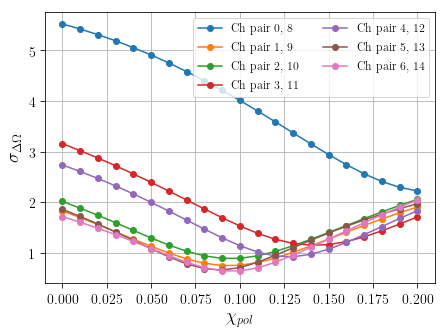

In [95]:
plt.figure(figsize=(7,5))
for i in range(0,7):
    plt.plot(chi,rms[i], marker = "o", label = "Ch pair %i, %i"%(i,i+8))
plt.legend(ncol=2)
plt.grid()
plt.xlabel("$\chi_{pol}$")
plt.ylabel("$\sigma_{\Delta\Omega}$")

No handles with labels found to put in legend.


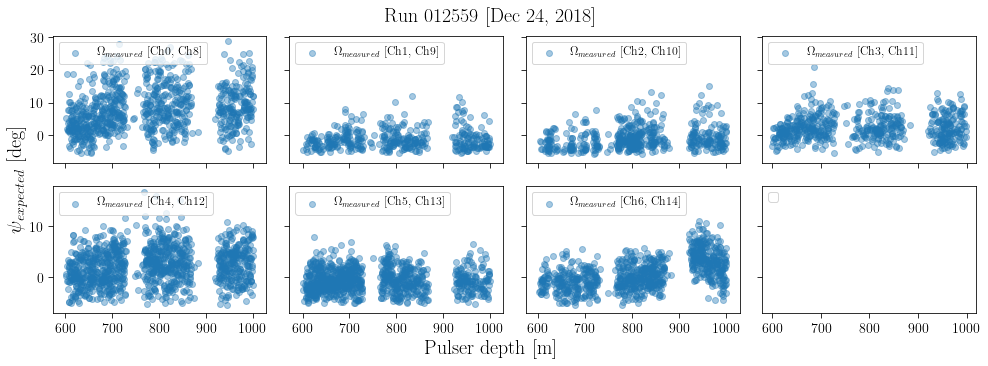

In [111]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
axs[0].scatter(SpiceCore0Loop.interp_depth, SpiceCore0Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch0, Ch8]")
axs[1].scatter(SpiceCore1Loop.interp_depth, SpiceCore1Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch1, Ch9]")
axs[2].scatter(SpiceCore2Loop.interp_depth, SpiceCore2Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch2, Ch10]")
axs[3].scatter(SpiceCore3Loop.interp_depth, SpiceCore3Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch3, Ch11]")
axs[4].scatter(SpiceCore4Loop.interp_depth, SpiceCore4Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch4, Ch12]")
axs[5].scatter(SpiceCore5Loop.interp_depth, SpiceCore5Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch5, Ch13]")
axs[6].scatter(SpiceCore6Loop.interp_depth, SpiceCore6Loop.Psi, alpha = 0.4, label = "$\Omega_{measured}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\psi_{expected}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlim(350,1200)
#     ax.set_ylim(0,40)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(depthArr,np.array(pol),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCorePsiScatter_run012559.png', dpi=250)


## Scatter

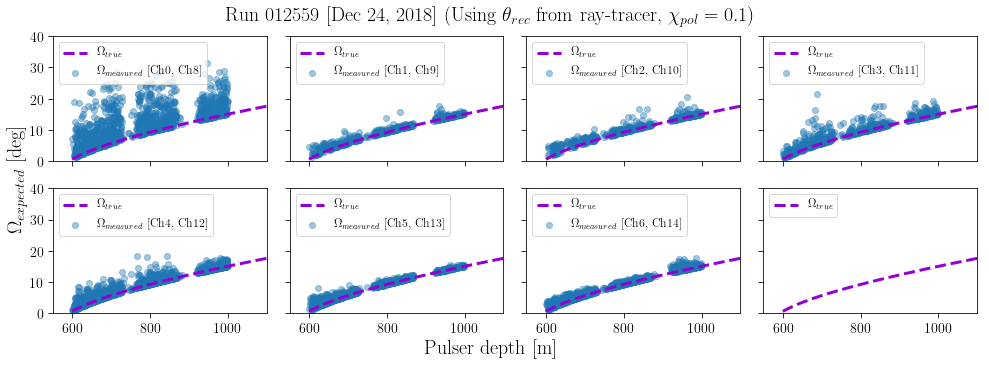

In [104]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
axs[0].scatter(SpiceCore0Loop.interp_depth, SpiceCore0Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch0, Ch8]")
axs[1].scatter(SpiceCore1Loop.interp_depth, SpiceCore1Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch1, Ch9]")
axs[2].scatter(SpiceCore2Loop.interp_depth, SpiceCore2Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch2, Ch10]")
axs[3].scatter(SpiceCore3Loop.interp_depth, SpiceCore3Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch3, Ch11]")
axs[4].scatter(SpiceCore4Loop.interp_depth, SpiceCore4Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch4, Ch12]")
axs[5].scatter(SpiceCore5Loop.interp_depth, SpiceCore5Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch5, Ch13]")
axs[6].scatter(SpiceCore6Loop.interp_depth, SpiceCore6Loop.Omega_reco, alpha = 0.4, label = "$\Omega_{measured}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\Omega_{expected}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(550,1100)
    ax.set_ylim(0,40)
    ax.set(xlabel="", ylabel = "")
    ax.plot(depthArr,np.array(pol),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018] (Using $\\theta_{rec}$ from ray-tracer, $\chi_{pol} = %0.1f$)"%X_pol, fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/NewSpiceCoreScatter_run012559_chi_0.1.png', dpi=250)


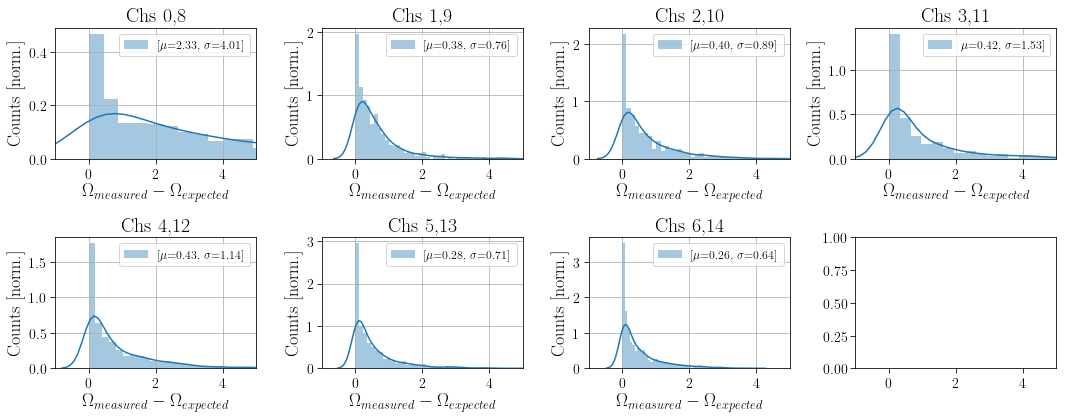

In [106]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()
delta = -1*(SpiceCore0ForInterp.Omega_true-SpiceCore0Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = -1*(SpiceCore1ForInterp.Omega_true-SpiceCore1Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 1,9")

delta = -1*(SpiceCore2ForInterp.Omega_true-SpiceCore2Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[2]);
axs[2].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[2].set_ylabel("Counts [norm.]")
axs[2].legend()
axs[2].grid()
axs[2].title.set_text("Chs 2,10")

delta = -1*(SpiceCore3ForInterp.Omega_true-SpiceCore3Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[3]);
axs[3].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[3].set_ylabel("Counts [norm.]")
axs[3].legend()
axs[3].grid()
axs[3].title.set_text("Chs 3,11")

delta = -1*(SpiceCore4ForInterp.Omega_true-SpiceCore4Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[4]);
axs[4].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[4].set_ylabel("Counts [norm.]")
axs[4].legend()
axs[4].grid()
axs[4].title.set_text("Chs 4,12")

delta = -1*(SpiceCore5ForInterp.Omega_true-SpiceCore5Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[5]);
axs[5].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[5].set_ylabel("Counts [norm.]")
axs[5].legend()
axs[5].grid()
axs[5].title.set_text("Chs 5,13")

delta = -1*(SpiceCore6ForInterp.Omega_true-SpiceCore6Loop.Omega_reco)
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[6]);
axs[6].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[6].set_ylabel("Counts [norm.]")
axs[6].legend()
axs[6].grid()
axs[6].title.set_text("Chs 6,14")

for ax in axs:
    ax.set_xlim(-1,5)
plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_run012559.png', dpi=250)

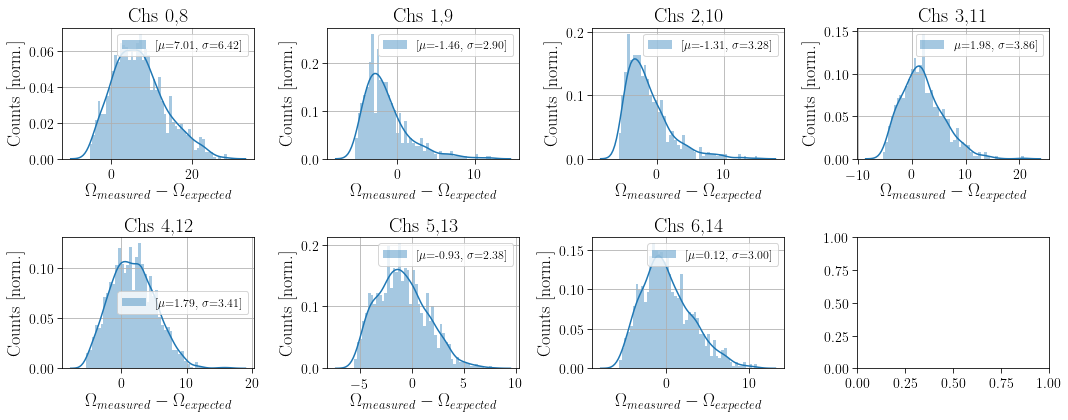

In [108]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()
delta = (SpiceCore0Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = (SpiceCore1Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 1,9")

delta = (SpiceCore2Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[2]);
axs[2].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[2].set_ylabel("Counts [norm.]")
axs[2].legend()
axs[2].grid()
axs[2].title.set_text("Chs 2,10")

delta = (SpiceCore3Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[3]);
axs[3].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[3].set_ylabel("Counts [norm.]")
axs[3].legend()
axs[3].grid()
axs[3].title.set_text("Chs 3,11")

delta = (SpiceCore4Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[4]);
axs[4].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[4].set_ylabel("Counts [norm.]")
axs[4].legend()
axs[4].grid()
axs[4].title.set_text("Chs 4,12")

delta = (SpiceCore5Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[5]);
axs[5].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[5].set_ylabel("Counts [norm.]")
axs[5].legend()
axs[5].grid()
axs[5].title.set_text("Chs 5,13")

delta = (SpiceCore6Loop.Psi)
delta_mean= np.mean(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[6]);
axs[6].set_xlabel("$\\Omega_{measured}-\\Omega_{expected}$")
axs[6].set_ylabel("Counts [norm.]")
axs[6].legend()
axs[6].grid()
axs[6].title.set_text("Chs 6,14")

plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_run012559.png', dpi=250)

(array([353., 479., 246., 105.,  43.,   6.,   2.,   1.,   1.,   1.]),
 array([-4733608.10187939,  -256965.21331961,  4219677.67524017,
         8696320.56379996, 13172963.45235974, 17649606.34091952,
        22126249.22947931, 26602892.11803909, 31079535.00659887,
        35556177.89515866, 40032820.78371844]),
 <a list of 10 Patch objects>)

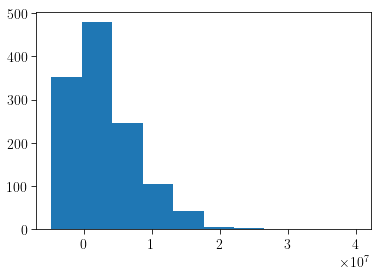

In [114]:
plt.hist(SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)